In [54]:
import numpy as np
import scipy as sp
from scipy.sparse import diags
from scipy.sparse import csr_array
from scipy.sparse import csr_matrix
from scipy.sparse import linalg
import math
import timeit
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Pre

In [92]:

class SimulationGrid:

    def __init__(self,L,N, k = 3, _type = 'Square', method = 'Fast', eigen = 'True'):
        """

        Creates a simulation grid.

        Inputs:

            - L: Square size, rectangle shape or circle diameter. Without considering boundaries
            - N: Discretization pints for Square side, Rectangle small side and Diameter of circle
            - k: Number of eigen values
        """
        self.L = L
        self.N = N
        self.dx = L/(N-1)
        self.k = k
        self.method = method
        self.eigen = eigen
        self.initialize(_type)
        self.data = [] #For simulations

    def initialize(self,  _type):
        """
        Initializes the v vector and M matrix in function of the type of grid
        """
        if _type == 'Square':
            self.times = timeit.default_timer()
            self.M = self.m_square()/(self.dx**2)
            self.times = timeit.default_timer() - self.times
        elif _type == 'Rectangle':
            self.times = timeit.default_timer()
            self.M = self.m_rectangle()/(self.dx**2)
            self.times = timeit.default_timer() - self.times
        elif _type == 'Circle':
            self.times = timeit.default_timer()
            self.M, self.M_g = self.m_circle()
            self.M = self.M/(self.dx**2)
            self.times = timeit.default_timer() - self.times
            self.M_2 = np.copy(-self.M*(self.dx**2))
        else:
            print("That does not work")
        
        if self.eigen == 'True' and k != "Full":

            self.eigenvalues, self.eigenvectors = sp.sparse.linalg.eigs(self.M, k = self.k, sigma = 0.001)
            self.eigenvalues = np.real(self.eigenvalues)
            self.eigenvectors = np.real(self.eigenvectors)
            self.eigenfreq= np.sqrt(np.abs(self.eigenvalues))
            
        elif self.eigen == 'True' and k == "Full":
            self.eigenvalues, self.eigenvectors = sp.linalg.eigh(self.M)
            self.eigenvalues = np.real(self.eigenvalues)
            self.eigenvectors = np.real(self.eigenvectors)
            self.eigenfreq= np.sqrt(np.abs(self.eigenvalues))

    
    def m_square(self):
        """
        Considers the grid as a square of size L
        """
        n = self.N*self.N 
        
        if self.method == 'Fast':
            x_diag = np.ones(n-1)
            x_diag[np.arange(1,n) % self.N == 0] = 0
            y_diag = np.ones(n - self.N)

            d = [y_diag, x_diag, np.full(n,-4), x_diag, y_diag]
            
            return diags(d , [-self.N,-1,0,1,self.N]).toarray()

        else:
            
            M = np.zeros((n, n))
            for i in range(n):
                M[i, i] = -4
                for j in range(n):
                    if j == i -self.N or j == i + self.N:
                        M[i,j] =  1
                    elif (j == i - 1) and ((j+1) % self.N != 0):
                        M[i,j] = 1
                    elif (j == i +1) and ((j)%self.N != 0):
                        M[i,j] = 1
            return M
        
    def m_rectangle(self):
        """
        Considers the grid as a rectangle of heigh of L and length 2*L
        Inputs:
            - m: Scale from L for Y axis
        """
        n = (self.N)*(self.N)*2
        
        if self.method == 'Fast':
            x_diag = np.ones(n-1)
            x_diag[np.arange(1,n) % self.N == 0] = 0

            y_diag = np.ones(n - self.N)

            d = [y_diag, x_diag, np.full(n,-4), x_diag, y_diag]
            return diags(d , [-self.N,-1,0,1,self.N]).toarray()
        
        else:
            M = np.zeros((n, n))
            for i in range(n):
                M[i, i] = -4
                for j in range(n):
                    if j == i -self.N or j == i + self.N:
                        M[i,j] =  1
                    elif (j == i - 1) and ((j+1) % self.N != 0):
                        M[i,j] = 1
                    elif (j == i +1) and ((j)%self.N != 0):
                        M[i,j] = 1
            
            return M
        
    def m_circle(self):
        """
        Considers the grid as a circle of diameter N. For this discretization, if N is par, then the center is ont, if impair it is 
        """
        n = (self.N)*(self.N)

        M = self.m_square()
        
        center_xy = self.L/2

        distances = np.sqrt(np.sum((np.indices((self.N,self.N))*self.dx - center_xy)**2, axis = 0))
        M_g = np.copy(distances)
        
        positions = np.where(distances.flatten() > self.L/2)[0]
        positions = positions[positions != int(np.floor(n/2))]
        
        
        M_g[M_g > L/2] = 0
        M_g[M_g != 0] = 1
        M_g[int(np.floor(self.N/2)),int(np.floor(self.N/2))] = 1
        
        M = np.delete(M, positions, axis = 0)
        M = np.delete(M, positions, axis = 1)

        return M,M_g

        
    def direct_method(self):
        n = self.M_2.shape[0]
        
        center_xy = L/2
    
        distances = np.arange(self.N)*self.dx - center_xy

        
        source_2d = [np.argmin(np.abs(distances - 1.2)),np.argmin(np.abs(distances - 0.6))]
        source_2d[0] = self.M_g.shape[0] - source_2d[0] - 1

        M_sum = np.copy(self.M_g.flatten())
        pos = (source_2d[0]+1)*self.N + source_2d[1]
        source_1d = int(np.sum(M_sum[:pos]))

        
        b = np.zeros(n)
        b[source_1d + 1] = 1
        b[source_1d - 1] = 1

        r = self.M_2[source_1d]
        
        up = np.max(np.where(r[source_1d + 1:] != 0))
        down =  np.min(np.where(r[:source_1d] != 0))
  
        
        b[source_1d + up] = 1
        b[down] = 1
        
        M_2 = np.delete(self.M_2, source_1d, axis = 0)
        M_2 = np.delete(M_2, source_1d, axis = 1)
        self.M_2 = M_2
        b = np.delete(b, source_1d)
        self.b = b
        c = sp.sparse.linalg.spsolve(csr_matrix(M_2),b)
        c = np.insert(c, source_1d, 1)
        
        return c

    def time_dependent(self,T,n_steps):
        A = 1
        B =  1
        self.data1 = [self.eigenvectors[:,0]*(A*np.cos(self.eigenfreq[0])  + B*np.sin(self.eigenfreq[0]*0))]
        self.data2 = [self.eigenvectors[:,1]*(A*np.cos(self.eigenfreq[1])  + B*np.sin(self.eigenfreq[1]*0))]
        self.data3 = [self.eigenvectors[:,2]*(A*np.cos(self.eigenfreq[2])  + B*np.sin(self.eigenfreq[2]*0))]
        self.dt =  T/n_steps
        dt = self.dt

        for t in range(1,n_steps):
            T_t = A*np.cos(self.eigenfreq[0])  + B*np.sin(self.eigenfreq[0]*t*dt)
            self.data1.append(self.eigenvectors[:,0]*T_t)

            T_t = A*np.cos(self.eigenfreq[1])  + B*np.sin(self.eigenfreq[1]*t*dt)
            self.data2.append(self.eigenvectors[:,1]*T_t)

            T_t = A*np.cos(self.eigenfreq[2])  + B*np.sin(self.eigenfreq[2]*t*dt)
            self.data3.append(self.eigenvectors[:,2]*T_t)


    def plot(self):
        fig, ax = plt.subplots()       

        C = np.copy(self.data[1])
        
        n_steps = len(self.data)
        x = np.linspace(0, 1, self.N)
        y = np.linspace(0, 1, self.N)
        x,y = np.meshgrid(x,y)

        ax = fig.add_subplot(111, projection='3d')
        im = ax.plot_surface(x, y, C.reshape((self.N,self.N)), cmap='viridis')

        ax.set_xlabel('X')  

        ax.set_ylabel('Y')  

        ax.set_zlabel('u(x,y,t)')

        ax.set_title('Time: 0 s')

        plt.show()

    def animation(self,save_animation = False, use = 0):
        """

        Animates the stepping scheme:

        Inputs:

            -   method: If using time_dependent or time_independent

            -   save_animation: True == it will save the animation, default is False
        """

        fig, ax = plt.subplots()
        if use == 0:
            data = self.data1
        elif use == 1:
            data = self.data2
        elif use == 2:    
            data = self.data3
        C = np.copy(data[0])
        
        n_steps = len(data)
        x = np.linspace(0, 1, self.N)
        y = np.linspace(0, 1, self.N)
        x,y = np.meshgrid(x,y)

        ax = fig.add_subplot(111, projection='3d')
        im = ax.plot_surface(x, y, C.reshape((self.N,self.N)), cmap='viridis')

        ax.set_xlabel('X')  

        ax.set_ylabel('Y')  
        z_min = np.min(data)  # Minimum value
        z_max = np.max(data)
        ax.set_zlabel('u(x,y,t)')
        ax.set_zlim(z_min, z_max)
        ax.set_title('Time: 0 s')
        cbar = fig.colorbar(im)
        
        anim = animation.FuncAnimation(fig,self.frame, fargs= (ax,x,y,data,use,z_min,z_max), frames=int(n_steps), interval = 0.0000001)

        if save_animation == True:

            print("Starting ")

            anim.save(f' time_dependent_diffusion_animation_{use+1}eig.mp4', fps=60)
            plt.close()

    def frame(self, iteration, ax,x,y,data,use,z_min,z_max):

        C = data[iteration]

        ax.clear()

        ax.set_title(f'Square Time dependent(t={np.round(iteration*self.dt, 2)}) s for {use + 1} eigen value')

        im = ax.plot_surface(x, y, C.reshape((self.N,self.N)), cmap='viridis')
        ax.set_zlim(z_min, z_max)

In [96]:
N = 40
L = 1
k = 3

square = SimulationGrid(L,N,k, _type = 'Square')
square.time_dependent(T = 10, n_steps = 500)
square.animation(save_animation = True, use = 0)
square.animation(save_animation = True, use = 1)
square.animation(save_animation = True, use = 2)

Starting 
Starting 
Starting 


# Part I

## A

Done

## B

sicpy linalg eig is for all matrices. scipy.inalg.eigh() is only specific for hermitian matrices and symatric matrices, thus if we want to compute all the eigenvalues and vector this is the best one and fastest, since it is specific for sparse matrices. Laslty, for computing only the smallest value sicpy.sparse.linalg.eigs() is used, since it is specific for sparse matrices and we can decide how many eigenvalues to compute, reducing the computational power

In [61]:
def v_conv(v,M):
    
    M_flat = M.flatten()
    v_flat = v.flatten()

    M_flat[M_flat == 1] = v_flat[:np.sum(M_flat == 1)]

    v_r = M_flat.reshape(M.shape)

    return v_r

In [62]:
N = 100
L = 1
k = 4

square = SimulationGrid(L,N,k, _type = 'Square')

rectangle = SimulationGrid(L,N,k, _type = 'Rectangle')

circle = SimulationGrid(L,N,k, _type = 'Circle')

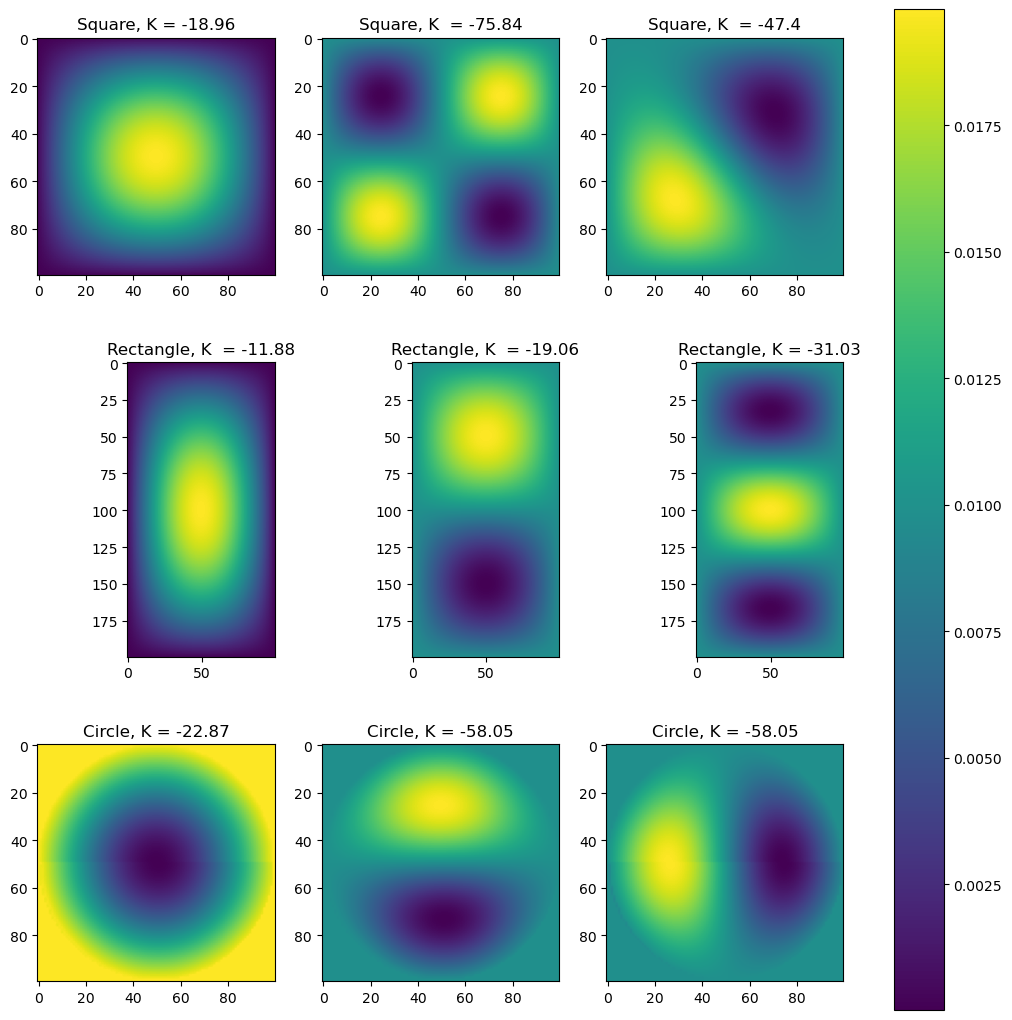

In [63]:
fig,axs = plt.subplots(3,3, figsize = (13,13))
axs = axs.flatten()
r = 1
m = 0
msq = 0
mrc = 0
mci = 0

axs[0].imshow(square.eigenvectors[:,msq].reshape(N,N))
axs[0].set_title(f'Square, K = {np.round(square.eigenvalues[m],2)}')

axs[1].imshow(square.eigenvectors[:,msq + r].reshape(N,N))
axs[1].set_title(f'Square, K  = {np.round(square.eigenvalues[m + r],2)}')

axs[2].imshow(square.eigenvectors[:,msq + 2*r].reshape(N,N))
axs[2].set_title(f'Square, K  = {np.round(square.eigenvalues[m + 2*r],2)}')


axs[3].imshow(rectangle.eigenvectors[:,mrc].reshape(2*N,N))
axs[3].set_title(f'Rectangle, K  = {np.round(rectangle.eigenvalues[m],2)}')

axs[4].imshow(rectangle.eigenvectors[:,mrc + r].reshape(2*N,N))
axs[4].set_title(f'Rectangle, K  = {np.round(rectangle.eigenvalues[m + r],2)}')

axs[5].imshow(rectangle.eigenvectors[:,mrc + 2*r].reshape(2*N,N))
axs[5].set_title(f'Rectangle, K = {np.round(rectangle.eigenvalues[m + 2*r],2)}')



axs[6].imshow(v_conv(circle.eigenvectors[:,mci],circle.M_g))
axs[6].set_title(f'Circle, K = {np.round(circle.eigenvalues[m],2)}')

axs[7].imshow(v_conv(circle.eigenvectors[:,mci + r],circle.M_g))
axs[7].set_title(f'Circle, K = {np.round(circle.eigenvalues[m + r],2)}')

axs[8].imshow(v_conv(circle.eigenvectors[:,mci + 2*r],circle.M_g))
axs[8].set_title(f'Circle, K = {np.round(circle.eigenvalues[m + 2*r],2)}')

fig.colorbar(axs[0].imshow(square.eigenvectors[:, msq].reshape(N, N)), ax=axs, orientation='vertical')


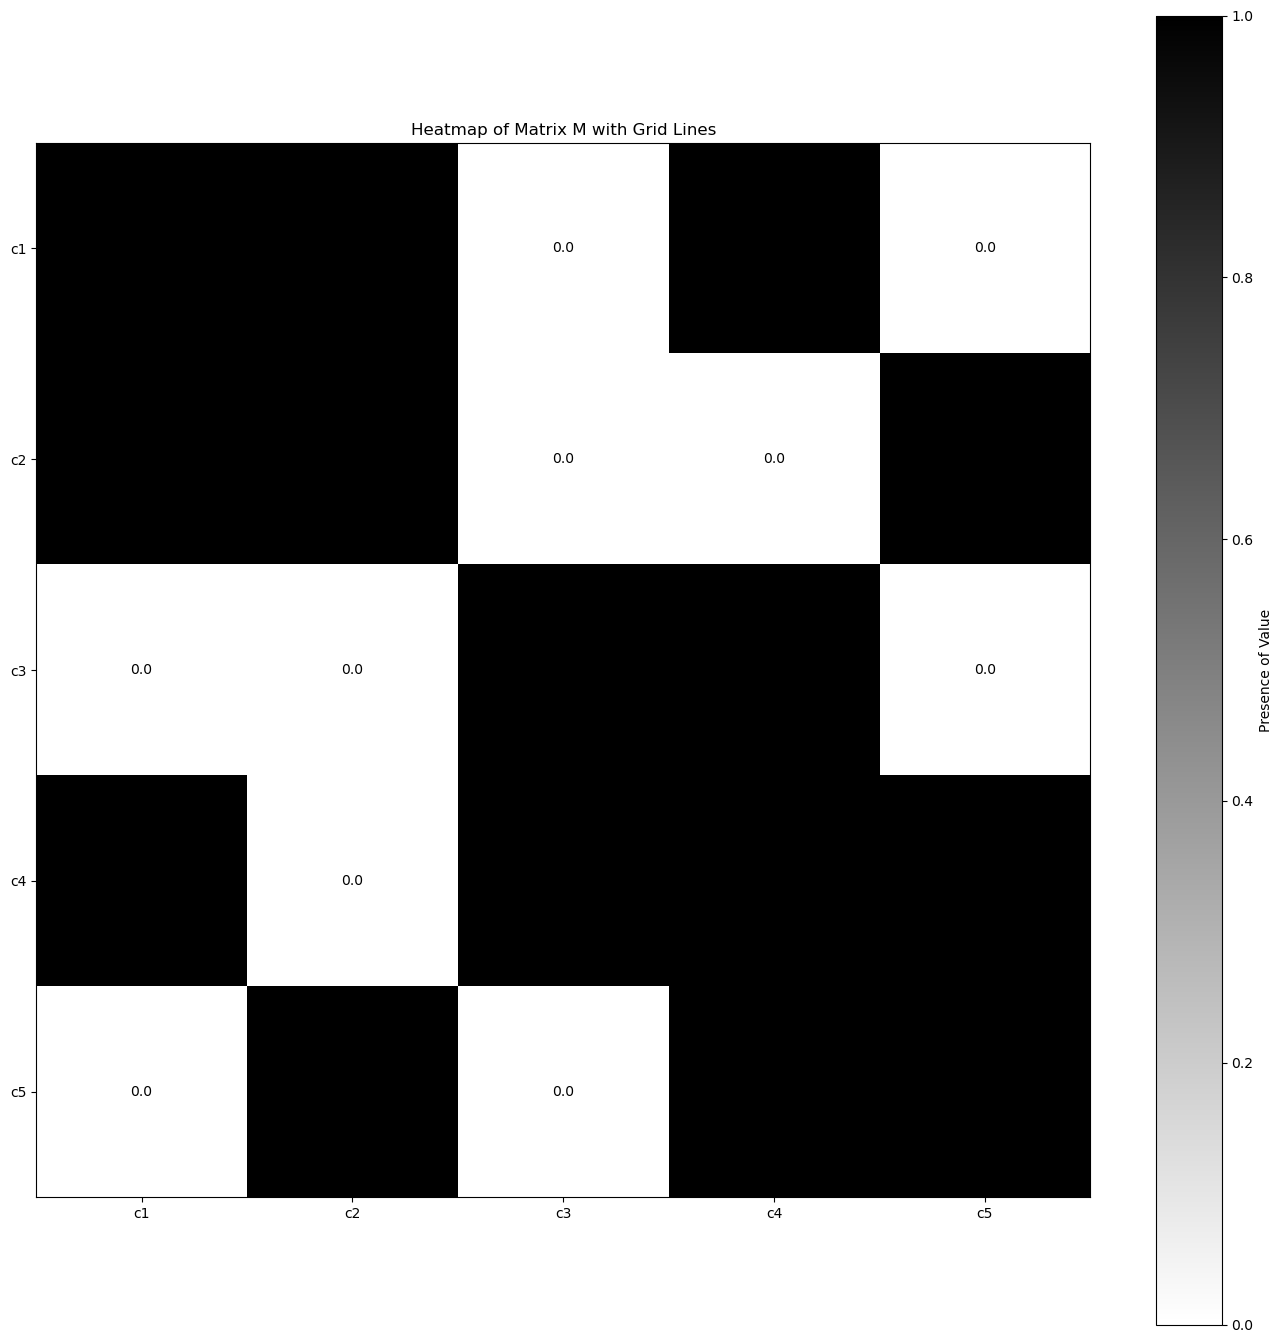

In [6]:

mask = circle.M != 0
M = circle.M
fig, axs = plt.subplots(1,1, figsize = (17,17))

plt.imshow(mask, cmap='binary', interpolation='nearest')


for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        plt.text(j, i, M[i, j], ha='center', va='center', color='black')

plt.xticks(np.arange(M.shape[1]), ['c{}'.format(i+1) for i in range(M.shape[1])])
plt.yticks(np.arange(M.shape[0]), ['c{}'.format(i+1) for i in range(M.shape[0])])

plt.title('Heatmap of Matrix M with Grid Lines')
plt.colorbar(label='Presence of Value')



plt.show()

## C

In [176]:
L = 1
num = 20

Ns = np.linspace(10,50,num = num, dtype = int)
time_f = np.zeros((3,num))
time_l = np.zeros((3,num))

for i,N in enumerate(Ns):
    square = SimulationGrid(L,N, _type = 'Square',method = 'Slow', eigen= 'False')
    time_l[0,i] = square.times
 
    square = SimulationGrid(L,N, _type = 'Square', eigen= 'False')
    time_f[0,i] = square.times

    rectangle = SimulationGrid(L,N, _type = 'Rectangle',method = 'Slow', eigen= 'False')
    time_l[1,i] = rectangle.times

    rectangle = SimulationGrid(L,N, _type = 'Rectangle', eigen= 'False')
    time_f[1,i] = rectangle.times

    circle = SimulationGrid(L,N, _type = 'Circle',method = 'Slow', eigen= 'False')
    time_l[2,i] = circle.times

    circle = SimulationGrid(L,N, _type = 'Circle', eigen= 'False')
    time_f[2,i] = circle.times

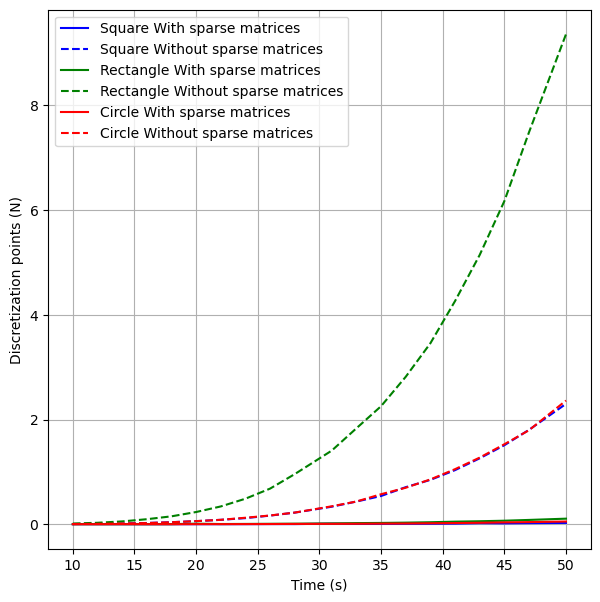

In [177]:
fig,axs = plt.subplots(1,1, figsize = (7,7))

names = ['Square', 'Rectangle', 'Circle']
colors = ['b','g','r']
for i in range(3):
    axs.plot(Ns,time_f[i],color = colors[i] , label = f'{names[i]} With sparse matrices')
    axs.plot(Ns,time_l[i], color = colors[i], linestyle = '--',label = f'{names[i]} Without sparse matrices')

axs.set_ylabel('Discretization points (N)')
axs.set_xlabel('Time (s)')
axs.grid(True)
axs.legend()

## D

In [266]:
T = 20
Ls = np.linspace(1,30, num = T)
Ns = np.linspace(5,60, num = T, dtype = int)

N = 50
L = 10
k = 5

L_change_sq = np.zeros((5,T))
L_change_rc = np.zeros((5,T))
L_change_ci = np.zeros((5,T))

N_change_rc = np.zeros((5,T))
N_change_sq = np.zeros((5,T))
N_change_ci = np.zeros((5,T))

for j,Li in enumerate(Ls):
    square = SimulationGrid(Li,N,k, _type = 'Square')
    rectangle = SimulationGrid(Li,N,k, _type = 'Rectangle')
    circle = SimulationGrid(Li,N,k, _type = 'Circle')
    for i in range(k):
        L_change_sq[i,j] = np.sqrt(square.eigenvalues[i])
        L_change_rc[i,j] = np.sqrt(rectangle.eigenvalues[i])
        L_change_ci[i,j] = np.sqrt(circle.eigenvalues[i])
    

for j,Ni in enumerate(Ns):
    square = SimulationGrid(L,Ni,k, _type = 'Square')
    rectangle = SimulationGrid(L,Ni,k, _type = 'Rectangle')
    circle = SimulationGrid(L,Ni,k, _type = 'Circle')
    for i in range(k):
        N_change_sq[i,j] = np.sqrt(square.eigenvalues[i])
        N_change_rc[i,j] = np.sqrt(rectangle.eigenvalues[i])
        N_change_ci[i,j] = np.sqrt(circle.eigenvalues[i])


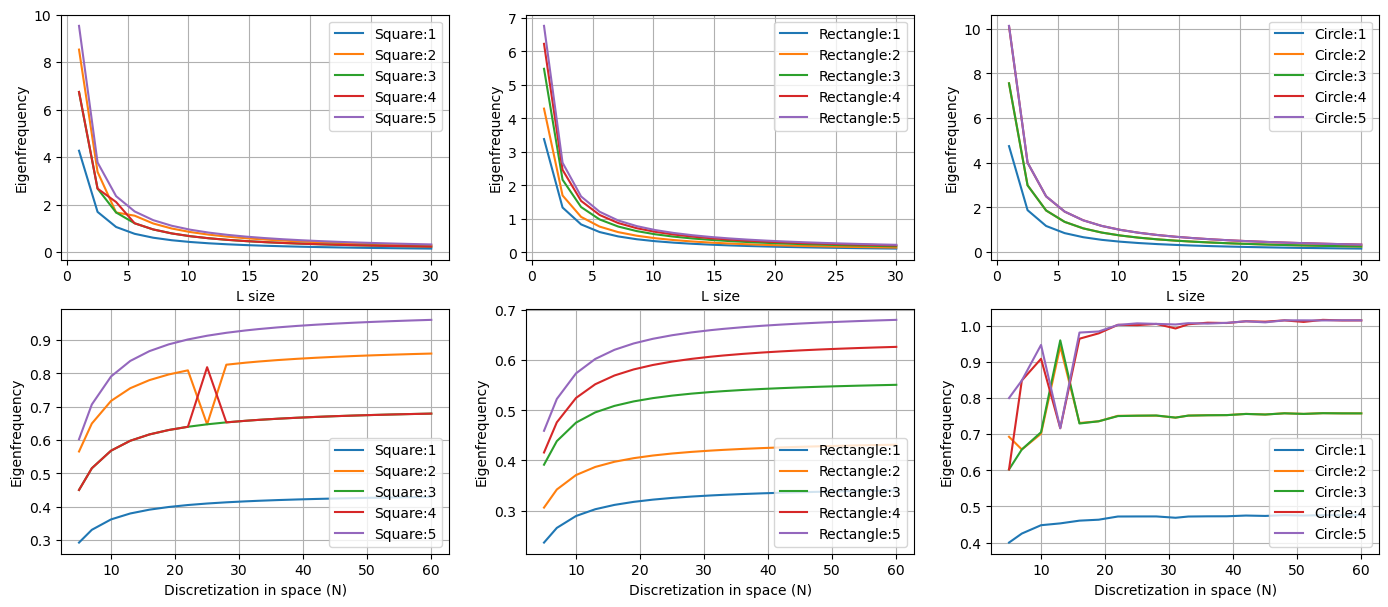

In [267]:
L_change = [L_change_sq, L_change_rc, L_change_ci]
N_change = [N_change_sq, N_change_rc, N_change_ci]

fig,axs = plt.subplots(3,2, figsize = (17,12))
names = ['Square', 'Rectangle', 'Circle']
eigens = ['1','2','3','4','5']
colors = ['b','g','r']
axs = axs.flatten()
for i in range(6):
    for j in range(k):
        if i < 2 :
            axs[i].plot(Ls,L_change[i][j], label = f'{names[i]}:{eigens[j]}')
            axs[i].set_xlabel('L size')
            axs[i].set_ylabel('Eigenfrequency')
            axs[i].legend()
            axs[i].grid(True)
            
        elif i < 4:
            axs[i].plot(Ns,N_change[i - 3][j], label = f'{names[i - 3]}:{eigens[j]}')
            axs[i].set_xlabel('Discretization in space (N)')
            axs[i].set_ylabel('Eigenfrequency')
    
            axs[i].legend()
            axs[i].grid(True)
        elif i < 6:


## E

# Part II

## G

In [376]:
L = 4
N = 120
circle = SimulationGrid(L,N, _type = 'Circle',eigen = 'False')
c = circle.direct_method()


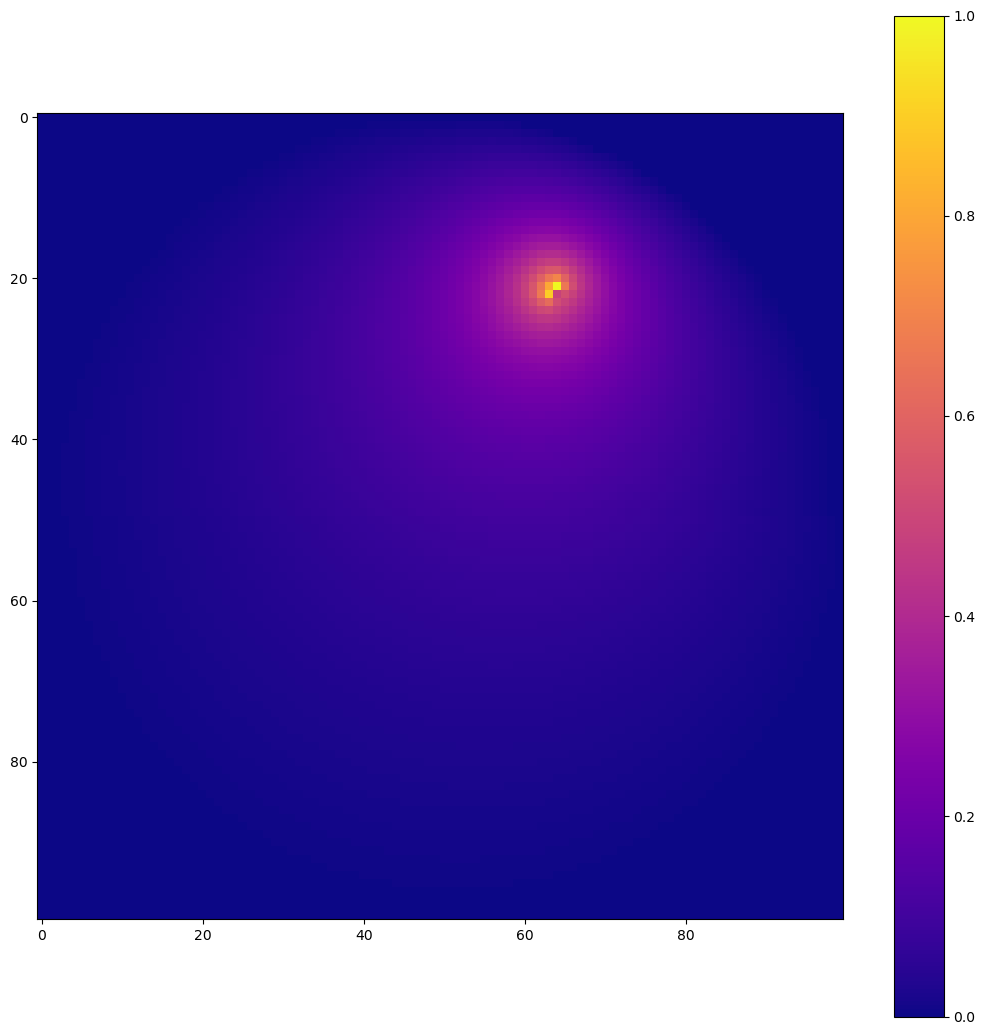

In [377]:
fig,axs = plt.subplots(1,1, figsize = (13,13))

im = axs.imshow(v_conv(c,circle.M_g), cmap= 'plasma')

fig.colorbar(im, ax=axs, orientation='vertical')



We observe a shift to the right in the diffusion, since is closer to the boundary

## E

For the matrix M and b, first the difusion equation the time derivate is set to 0 (as in equilibrium the system does not change):

$0 = c^2 \nabla^2 u$

Then, assuming c = 1 and discretizing we obtain:

\begin{align*}
0 &= \nabla^2 u \\
&\approx \frac{u(x+h, y) - 2u(x, y) + u(x-h, y)}{h^2} + \frac{u(x, y+h) - 2u(x, y) + u(x, y-h)}{h^2} = \\
-u(x+h, y) + 4u(x, y) - u(x-h, y) - u(x, y+h)- u(x, y-h) = 0 (\text{Note change of sign})
\end{align*}

Where h is the grid spacing. Note that, the source poitn is not updated, since it reamains constatn to 1  over time. Thus for the neighorins point we have up above, right and left:
\begin{equation}
-u(x+h, y) + 4u(x, y) - u(x-h, y) - u(x, y+h) = u(x, y-h) = 1
\end{equation}

\begin{equation}
-u(x+h, y) + 4u(x, y) - u(x-h, y) - u(x, y-h) = u(x, y+h) = 1
\end{equation}

\begin{equation}
-u(x+h, y) + 4u(x, y)  - u(x, y+h) = u(x-h, y) = 1
\end{equation}

\begin{equation}
 4u(x, y) - u(x-h, y) - u(x, y+h) = u(x+h, y) = 1
\end{equation}

And for the boundary values, the concentrations are just 0.

Thus for $N$ discretized points in each axis (without including boundary points), we can define then our system of equation by the Matrix NxN $\textbf{M}$ as with -4 in the diagonal, and 1 in upper diagonal, lower diagonal and in the diagonal corresponding up and down. See figure bellow as example of N = 4




In [324]:
L = 4
N = 8
circle = SimulationGrid(L,N, _type = 'Circle',eigen = 'False')
c = circle.direct_method()
M = circle.M_2
colors = [(0.5, 0.5, 0.5)]  # RGB tuple for gray color
cmap_name = 'plain_gray'

fig, axs = plt.subplots(1,1, figsize=(17, 17))
plt.imshow(M, cmap='gray', interpolation='nearest')

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if M[i, j] != 0:
            plt.text(j, i, M[i, j], ha='center', va='center', color='black')

plt.xticks(np.arange(M.shape[1]), ['c{}'.format(i+1) for i in range(M.shape[1])])
plt.yticks(np.arange(M.shape[0]), ['c{}'.format(i+1) for i in range(M.shape[0])])

plt.title('Heatmap of Matrix M with Grid Lines')

plt.show()

0
(array([3], dtype=int64),)


ValueError: zero-size array to reduction operation minimum which has no identity

For the vector $b$ , follwing the above equatoins INSERT REFERECNE. Is a vector with all 0 and 1 on the neigthouring points of the source. See figure bellow as example of N = 4

In [276]:
L = 4
N = 20
circle = SimulationGrid(L,N, _type = 'Circle',eigen = 'False')
c = circle.direct_method()
print(circle.b)

23
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
